# <img src="../images/sberbank.png">
# <center> Лабораторная 3 </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt

from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings
from google.colab import drive

drive.mount('/content/drive')
%matplotlib inline
filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


Mounted at /content/drive


In [3]:
# Считываем данные
tr_mcc_codes = pd.read_csv('/content/drive/MyDrive/data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('/content/drive/MyDrive/data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('/content/drive/MyDrive/data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('/content/drive/MyDrive/data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('/content/drive/MyDrive/data/gender_test.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

del transactions

In [4]:
# Функции, которыми можно пользоваться для построения классификатора, 
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

### Так как код для оценки модели на тренировочных данных и её применения на тестовых данных уже дан, то мы будем работать над тем, чтобы создать переменные для улучшения результатов моделирования. 

### (!) В рамках данного задания Вы можете делать всё, что угодно - использовать другие алгоритмы и/или их комбинации, подбирать гиперпараметры своих моделей, отбирать переменые, etc. Мы создали шаблон для простоты и для Вашего понимания верхнеуровневого процесса разработки модели, опустив при этом большое число деталей.

## Basic features
Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели (не забывайте, что с этим Вы можете тоже экспериментировать).

In [5]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [6]:
tqdm_notebook.pandas(desc="Progress:")

def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)

In [7]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.619+-0.004, Trees: 55


In [8]:
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

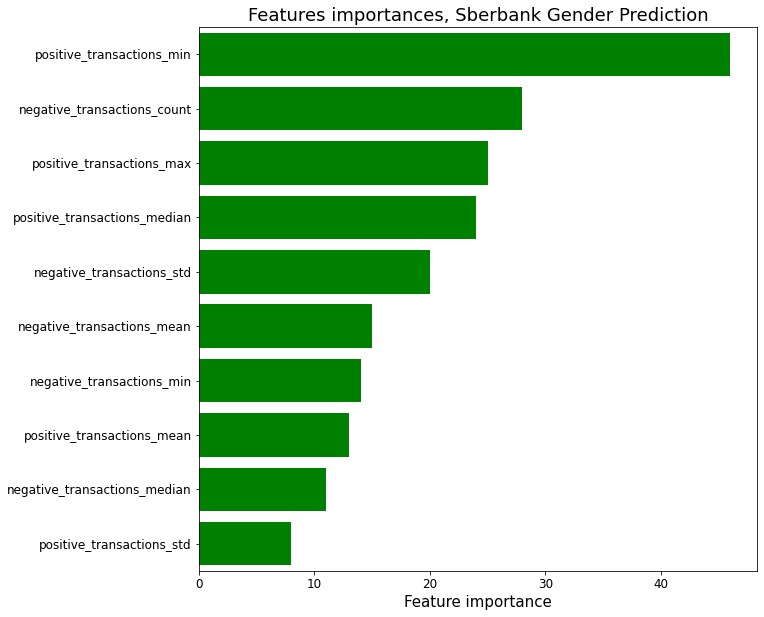

In [9]:
draw_feature_importances(clf, 10)

In [12]:
submission.to_csv('/content/drive/MyDrive/data/basic_features_submission.csv')

### Видим, что результат на кросс-валидации - 62.5% ROC AUC.

## Advanced features
Добавим дополнительные переменные по каждому пользователю в модель. <br>
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий. <br>
То есть если, например, клиент в 70% случае совершал ночные траты, то мы получим вектор [0.7, 0.3] для этого случая в качестве частот транзакций ночью/днём.

In [13]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [14]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

In [15]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

In [16]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.682+-0.007, Trees: 175


In [17]:
### Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

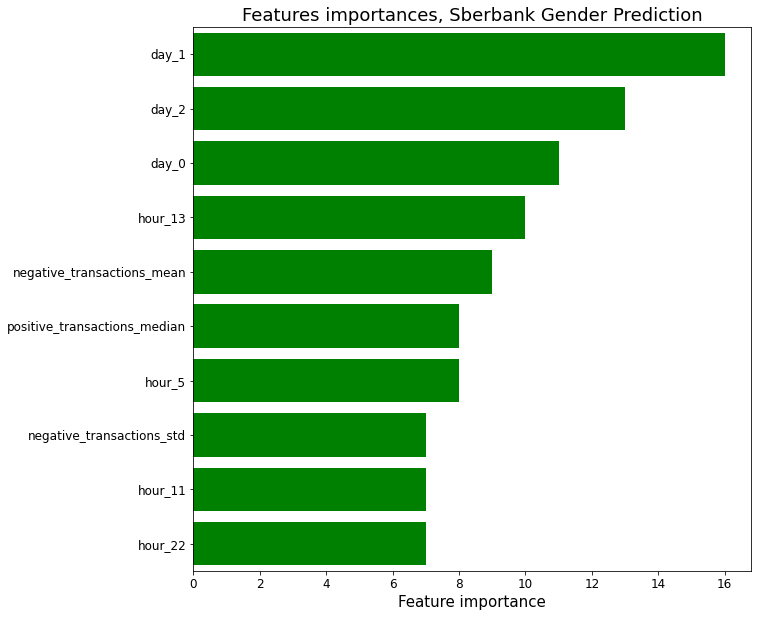

In [18]:
draw_feature_importances(clf, 10)

### Добавление новых переменных улучшило наши результаты ROC AUC с 62.5% до 68.2%, на тестовой выборке результат будет аналогичным, так что мы явно не переобучились. При этом есть куда стремиться!

In [19]:
submission.to_csv('/content/drive/MyDrive/data/submission_advanced.csv')

# (!) Цель задания:
## Полученная модель должна иметь ROC AUC на Public-части тестовой выборки (на лидерборде) не менее 80%.

In [20]:
transactions_train.columns

Index(['tr_datetime', 'mcc_code', 'tr_type', 'amount', 'term_id', 'gender',
       'day', 'hour', 'night'],
      dtype='object')

In [21]:
def features_creation(x): 

    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))

    tmp = x.groupby('mcc_code')['amount'].count()
    tmp.index = tmp.index.map(lambda x: 'mcc_code_count' + str(x))
    features.append(tmp)

    tmp = x.groupby('tr_type')['amount'].count()
    tmp.index = tmp.index.map(lambda x: 'tr_type_count' + str(x))
    features.append(tmp)

    tmp = x.groupby('mcc_code')['amount'].mean()
    tmp.index = tmp.index.map(lambda x: 'mcc_code_mean' + str(x))
    features.append(tmp)

    tmp = x.groupby('tr_type')['amount'].mean()
    tmp.index = tmp.index.map(lambda x: 'tr_type_mean' + str(x))
    features.append(tmp)

    return pd.concat(features)

In [22]:
data = transactions_train.groupby(transactions_train.index).progress_apply(features_creation).unstack()

In [23]:
target = data.join(gender_train, how='inner')['gender']
cv_score(params, data, target)

Cross-validation, ROC AUC: 0.878+-0.006, Trees: 405


Полученная модель имеет ROC AUC на Public-части тестовой выборки (на лидерборде) не менее 80%, а именно порядка 87.8%. Это удовлетворяет поставленному условию.